In [1]:
import pandas as pd
import torch
import numpy as np
from lightning import pytorch as pl
from chemprop import data, models
import seaborn as sns
from chemprop import data, models
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt
import sys
import json
import os
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np
import json 
sys.path.append(os.path.abspath('../lrp_chemprop/'))
from Data_Preprocessor import Data_Preprocessor

# **5-fold cross-validation pipeline**

Given 17 training settings, which turns to 17x5 trained model for 5-fold CV, this pipeline is used to evaluate each model and store metrics in to a json file.

In [3]:
# Initilized container
train_metrics = {}
val_metrics = {}
test_metrics = {}
for metric in ['RMSE','MAE','R2']:
    for model in range(1,18):
        train_metrics[metric+'_'+str(model)] = []
        val_metrics[metric+'_'+str(model)] = []
        test_metrics[metric+'_'+str(model)] = []

In [ ]:
for model_id in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]:
    for fold in range(1,6):
        # Set up data path
        if model_id in [1,2,3,4,5,6,7]:
            split = f'split_random_{fold}'
            path = 'CDK2_diverse_data.csv'
        elif model_id in [8,9,10,11]:
            split = f'split_scaffold_{fold}'
            path = 'CDK2_diverse_data.csv'
        elif model_id in [12,13,14]:
            split = f'split_{fold}'
            path = 'CDK2_semi_data.csv'
        else:
            split = f'split_{fold}'
            path = 'CDK2_focus_data.csv'
        
            
        df_total = pd.read_csv(path)
        df_train = df_total[df_total[split]=='train']
        df_val = df_total[df_total[split]=='val']
        df_test = df_total[df_total[split]=='test']

        # Set up data_generator
        if model_id in [1,4,5,8,9,12,15]:
            addH=False
            HB=False
            morgan=False
        elif model_id in [6,7,10,11,14,17]:
            addH=False
            HB=True
            morgan=False
        elif model_id in [2,13,16]:
            addH=True
            HB=False
            morgan=False
        if model_id in [3]:
            addH=False
            HB=False
            morgan=True

        # Prepare data
        data_generator = Data_Preprocessor()
        train_dataset = data_generator.generate(df=df_train,
                              smiles_column='smiles',
                              target_column='docking_score',
                              addH=addH,
                              HB=HB, morgan = morgan)
        val_dataset = data_generator.generate(df=df_val,
                                    smiles_column='smiles',
                                    target_column='docking_score',
                                    addH=addH,
                                    HB= HB, morgan = morgan)
        test_dataset = data_generator.generate(df=df_test,
                                    smiles_column='smiles',
                                    target_column='docking_score',
                                    addH=addH,
                                    HB= HB, morgan = morgan)
        print(f'Complete data generator for model {model_id} -fold {fold}')

        # Load the model 
        model_path = f'hyperparam_optim_{model_id}/fold_{fold}.ckpt'
        model = models.MPNN.load_from_checkpoint(model_path).to('cpu')
        model_final = models.MPNN.load_from_checkpoint(f'hyperparam_optim_{model_id}/best_checkpoint.ckpt').to('cpu')

        model.message_passing.dropout.p=0
        model.predictor.ffn[1][1].p = 0
        model_final.message_passing.dropout.p=0
        model_final.predictor.ffn[1][1].p = 0

        print(f'Complete load model for model {model_id} - fold {fold}')

        # Set up trainer
        trainer = pl.Trainer(
            logger=False,
            enable_checkpointing=True, 
            enable_progress_bar=True,
            accelerator="auto",
            devices=1,
            max_epochs=100
        )
        
        # Predict for train-val set
        train_loader = data.build_dataloader(train_dataset,seed=2406, shuffle=False,batch_size=64)
        val_loader = data.build_dataloader(val_dataset,seed=2406, shuffle=False,batch_size=64)
        test_loader = data.build_dataloader(test_dataset,seed=2406, shuffle=False,batch_size=df_test.shape[0])
        device = next(model.parameters()).device
        with torch.no_grad():
            train_prediction = []
            for batch in train_loader:
                bmg,_,X_d,*_ = batch
                train_prediction.append((model(bmg,X_d=X_d)*model.predictor.output_transform.scale+model.predictor.output_transform.mean).reshape(-1))
            y_train_pred = torch.cat(train_prediction,dim=0)

        with torch.no_grad():
            val_prediction = []
            for batch in val_loader:
                bmg,_,X_d,*_ = batch
                val_prediction.append((model(bmg, X_d = X_d)*model.predictor.output_transform.scale+model.predictor.output_transform.mean).reshape(-1))
            y_val_pred = torch.cat(val_prediction,dim=0)

        

        y_train_true = train_dataset.Y.reshape(-1)
        y_val_true = val_dataset.Y.reshape(-1)
        

        y_train_pred = y_train_pred.cpu().numpy()
        y_val_pred = y_val_pred.cpu().numpy()
        print(f'Complete generate prediction for train-val of model {model_id} -fold  {fold}')
        
        # Record metrics
        rmse = root_mean_squared_error(y_train_true,y_train_pred)
        mae = mean_absolute_error(y_train_true,y_train_pred)
        r2 = r2_score(y_train_true,y_train_pred)
        train_metrics['RMSE_'+str(model_id)].append(rmse)
        train_metrics['MAE_'+str(model_id)].append(mae)
        train_metrics['R2_'+str(model_id)].append(r2)

        rmse = root_mean_squared_error(y_val_true,y_val_pred)
        mae = mean_absolute_error(y_val_true,y_val_pred)
        r2 = r2_score(y_val_true,y_val_pred)
        val_metrics['RMSE_'+str(model_id)].append(rmse)
        val_metrics['MAE_'+str(model_id)].append(mae)
        val_metrics['R2_'+str(model_id)].append(r2)

        
        # Predict for train-val set
        with torch.no_grad():
            test_prediction = []
            for batch in test_loader:
                bmg,_,X_d,*_ = batch
                test_prediction.append((model_final(bmg,X_d=X_d,V_d=None)*model.predictor.output_transform.scale+model.predictor.output_transform.mean).reshape(-1))
            y_test_pred = torch.cat(test_prediction,dim=0)

        y_test_true = test_dataset.Y.reshape(-1)
        y_test_pred = y_test_pred.cpu().numpy()
        print(f'Complete generate prediction for test of model {model_id} -fold  {fold}')

        # Record metrics
        for i in range(0,1):
            indices = np.random.choice(len(y_test_true),len(y_test_true),replace=True)
            y_test_true_sampled = y_test_true[indices]
            y_test_pred_sampled = y_test_pred[indices]
        
            rmse = root_mean_squared_error(y_test_true_sampled,y_test_pred_sampled)
            mae = mean_absolute_error(y_test_true_sampled,y_test_pred_sampled)
            r2 = r2_score(y_test_true_sampled,y_test_pred_sampled)
            test_metrics['RMSE_'+str(model_id)].append(rmse)
            test_metrics['MAE_'+str(model_id)].append(mae)
            test_metrics['R2_'+str(model_id)].append(r2)
        print(f'Complete all for {model_id} - {fold}')


    # Store results
    with open('CDK2_train_metrics.json', 'w') as f:
        json.dump(train_metrics, f, indent=4)

    with open('CDK2_val_metrics.json', 'w') as f:
        json.dump(val_metrics, f, indent=4)

    with open('CDK2_test_metrics.json', 'w') as f:
        json.dump(test_metrics, f, indent=4)    

# **Visualization**

To visualize the error bar, the Turkey post-hoc analysis was used to draw the 95% CI

In [ ]:
with open('CDK2/CDK2_test_metrics.json', 'r') as f:
    test_metrics = json.load(f)

with open('CDK2/CDK2_train_metrics.json', 'r') as f:
    train_metrics = json.load(f)

with open('CDK2/CDK2_val_metrics.json', 'r') as f:
    val_metrics = json.load(f)


- For RMSE, the relative values to dataset STD were caculated.
- For R2, the original values were used directly

In [ ]:
metric = 'RMSE'
train_metrics_rel = {}
val_metrics_rel = {}
test_metrics_rel = {}

df_1_11 = pd.read_csv('CDK2/CDK2_diverse_data.csv')
df_12_14 = pd.read_csv('CDK2/CDK2_semi_data.csv')
df_15_17 = pd.read_csv('CDK2/CDK2_focus_data.csv')

if metric == 'RMSE' or metric == 'MAE':
    for model in range(1,18):
        if model in range(1,8):
            train_metrics_rel[f'{metric}_{model}'] = np.array(train_metrics[f'{metric}_{model}'])/np.array([df_1_11[df_1_11[f'split_random_{i}']=='train']['docking_score'].std() for i in range(1,6)])
            val_metrics_rel[f'{metric}_{model}'] = np.array(val_metrics[f'{metric}_{model}'])/np.array([df_1_11[df_1_11[f'split_random_{i}']=='val']['docking_score'].std() for i in range(1,6)])
            test_metrics_rel[f'{metric}_{model}'] = np.array(test_metrics[f'{metric}_{model}'])/np.array([df_1_11[df_1_11[f'split_random_{i}']=='test']['docking_score'].std() for i in range(1,6)][0])
        elif model in range(8,12):
            train_metrics_rel[f'{metric}_{model}'] = np.array(train_metrics[f'{metric}_{model}'])/np.array([df_1_11[df_1_11[f'split_scaffold_{i}']=='train']['docking_score'].std() for i in range(1,6)])
            val_metrics_rel[f'{metric}_{model}'] = np.array(val_metrics[f'{metric}_{model}'])/np.array([df_1_11[df_1_11[f'split_scaffold_{i}']=='val']['docking_score'].std() for i in range(1,6)])
            test_metrics_rel[f'{metric}_{model}'] = np.array(test_metrics[f'{metric}_{model}'])/np.array([df_1_11[df_1_11[f'split_scaffold_{i}']=='test']['docking_score'].std() for i in range(1,6)][0])
        elif model in range(12,15):
            train_metrics_rel[f'{metric}_{model}'] = np.array(train_metrics[f'{metric}_{model}'])/np.array([df_12_14[df_12_14[f'split_{i}']=='train']['docking_score'].std() for i in range(1,6)])
            val_metrics_rel[f'{metric}_{model}'] = np.array(val_metrics[f'{metric}_{model}'])/np.array([df_12_14[df_12_14[f'split_{i}']=='val']['docking_score'].std() for i in range(1,6)])
            test_metrics_rel[f'{metric}_{model}'] = np.array(test_metrics[f'{metric}_{model}'])/np.array([df_12_14[df_12_14[f'split_{i}']=='test']['docking_score'].std() for i in range(1,6)][0])
        elif model in range(15,18):
            train_metrics_rel[f'{metric}_{model}'] = np.array(train_metrics[f'{metric}_{model}'])/np.array([df_15_17[df_15_17[f'split_{i}']=='train']['docking_score'].std() for i in range(1,6)])
            val_metrics_rel[f'{metric}_{model}'] = np.array(val_metrics[f'{metric}_{model}'])/np.array([df_15_17[df_15_17[f'split_{i}']=='val']['docking_score'].std() for i in range(1,6)])
            test_metrics_rel[f'{metric}_{model}'] = np.array(test_metrics[f'{metric}_{model}'])/np.array([df_15_17[df_15_17[f'split_{i}']=='test']['docking_score'].std() for i in range(1,6)][0])
else: 
    train_metrics_rel[f'{metric}_{model}'] = np.array(train_metrics[f'{metric}_{model}'],dtype=np.float64)
    val_metrics_rel[f'{metric}_{model}'] = np.array(val_metrics[f'{metric}_{model}'],dtype=np.float64)
    test_metrics_rel[f'{metric}_{model}'] = np.array(test_metrics[f'{metric}_{model}'],dtype=np.float64)


Melt the data to long-format

In [13]:
df_test = pd.DataFrame(test_metrics_rel)
df_test_melt = df_test.melt(var_name='Model',value_name='RMSE')
df_test_melt['Model'] = df_test_melt['Model'].str.replace('RMSE_','')
df_test_melt['Model'] = df_test_melt['Model']

df_train = pd.DataFrame(train_metrics_rel)
df_train_melt = df_train.melt(var_name='Model',value_name='RMSE')
df_train_melt['Model'] = df_train_melt['Model'].str.replace('RMSE_','')
df_train_melt['Model'] = df_train_melt['Model']

df_val = pd.DataFrame(val_metrics_rel)
df_val_melt = df_val.melt(var_name='Model',value_name='RMSE')
df_val_melt['Model'] = df_val_melt['Model'].str.replace('RMSE_','')
df_val_melt['Model'] = df_val_melt['Model']

The Tukey post-hoc was used to compared models

In [14]:
tukey_val = pairwise_tukeyhsd(endog=df_val_melt["RMSE"], groups=df_val_melt["Model"], alpha=0.05)
tukey_train = pairwise_tukeyhsd(endog=df_train_melt["RMSE"], groups=df_train_melt["Model"], alpha=0.05)
tukey_test = pairwise_tukeyhsd(endog=df_test_melt["RMSE"], groups=df_test_melt["Model"], alpha=0.05)

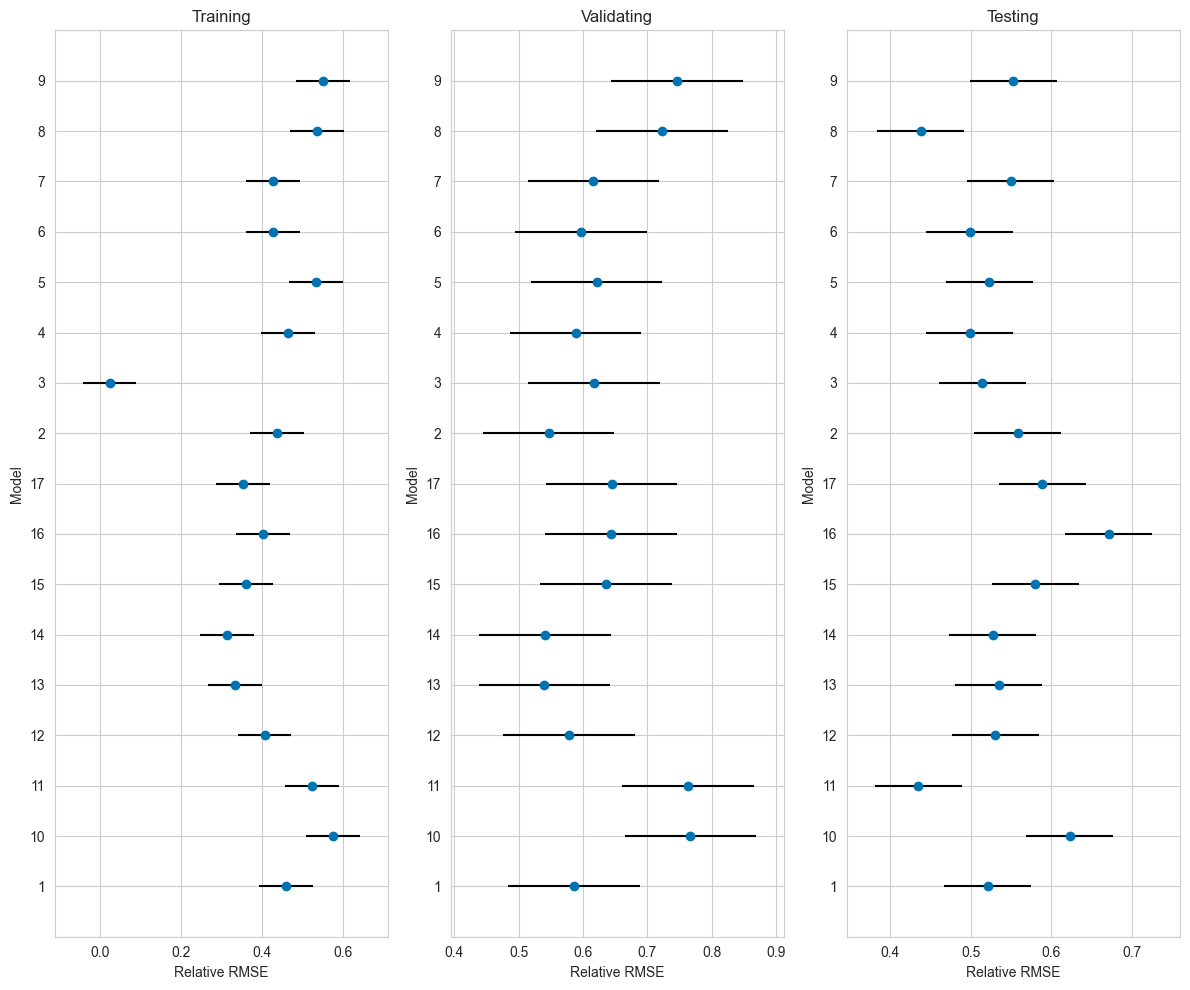

In [ ]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

# Plot on each subplot (replace tukey1, tukey2, tukey3 with your objects)
tukey_train.plot_simultaneous(None, figsize=(12, 10), xlabel='Relative RMSE', ylabel='Model', ax=axes[0])
tukey_val.plot_simultaneous(None, figsize=(12, 10), xlabel='Relative RMSE', ylabel='Model', ax=axes[1])
tukey_test.plot_simultaneous(None, figsize=(12, 10), xlabel='Relative RMSE', ylabel='Model', ax=axes[2])

# Apply settings to all subplots
for ax, title in zip(axes,['Training','Validating','Testing']):
    ax.grid(True)
    ax.set_title(title)

plt.tight_layout()
plt.show()


# **Extract model config**

In [ ]:
model_config = {'Target': [], 'Model': [], 'message-hidden-dim': [], 'depth': [], 'dropout': [],'ffn-hidden-dim': [], 'ffn-num-layers': [], 'add-h': [], 'HBD/HBA': []}

target = 'CDK2'
for model_id in range(1,18):
    model = models.MPNN.load_from_checkpoint(f'{target}/hyperparam_optim_{model_id}/best_checkpoint.ckpt')
    
    model_config['Target'].append(target)
    model_config['Model'].append(model_id)
    model_config['message-hidden-dim'].append(model.hparams.message_passing.d_h)
    model_config['depth'].append(model.hparams.message_passing.depth)
    model_config['dropout'].append(model.hparams.message_passing.dropout)
    model_config['ffn-hidden-dim'].append(model.hparams.predictor.hidden_dim)
    model_config['ffn-num-layers'].append(model.hparams.predictor.n_layers)

    if model_id in [2,13,16]:
        model_config['add-h'].append(True)
    else:
        model_config['add-h'].append(False)

    if model_id in [6,7,10,11,14,17]:
        model_config['HBD/HBA'].append(True)
    else:
        model_config['HBD/HBA'].append(False)

In [ ]:
model_config = pd.DataFrame(model_config)
model_config.to_csv('model_config.csv', index=False)